# Enter State Farm

In [1]:
#from theano.sandbox import cuda
#cuda.use('gpu0')

In [3]:
%matplotlib inline
from __future__ import print_function, division
path = '../../statefarm/imgs_by_driver/sample/'
#path = "data/state/sample/"
from importlib import reload
import zutils; reload(zutils)
from zutils import *
from IPython.display import FileLink
from keras.initializations import he_normal
from keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size=32

## Setup batches

In [5]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [6]:
batches.N

1500

In [7]:
batches.nb_sample

1500

# Simplest model

Tried a number of times, analyzed the output and saw the model was guessing the baseline - all one value. I lowered the learning rate but that still didn't help. Then I modified the initialization of the dense layer and that along with the lower learning rate got the model learning quickly.

1st
    - 2 epochs @ lr=.001 & init=glorot_uniform 
    - 2 epochs @ lr=.00001 & init=glorot_uniform 
    - still nothing better than .11 accuracy
    
2nd 
    - 2 epochs @ lr=.001 & init=he_normal
    - still northing better than .145 accuracy

3rd
    - 2 epochs @ lr=.00001 & init=glorot_uniform 
    - quickly .55 accuracy

In [ ]:
model = Sequential()
model.add(BatchNormalization(axis=1,input_shape=(3,224,224)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

In [ ]:
model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=2,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)

---
Take a look at a poorly performing model's predictions to get an idea of why its performing so poorly

In [48]:
np.round(model.predict_generator(val_batches,val_samples=val_batches.N)[:10],2)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

---
To determine the initialization of the dense layer, check its config. I've read he_normal/he_gaussian is a standard init so I'll try that

In [51]:
model.layers[2].get_config()

{'W_constraint': None,
 'W_regularizer': None,
 'activation': 'softmax',
 'activity_regularizer': None,
 'b_constraint': None,
 'b_regularizer': None,
 'bias': True,
 'init': 'glorot_uniform',
 'input_dim': 150528,
 'name': 'dense_4',
 'output_dim': 10,
 'trainable': True}

In [63]:
model = Sequential()
model.add(BatchNormalization(axis=1,input_shape=(3,224,224)))
model.add(Flatten())
model.add(Dense(10,activation='softmax',init=he_normal))

In [64]:
model.compile(optimizer=Adam(lr=.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [65]:
model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=2,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)

Epoch 1/2
1500/1500 [==============================] - 61s - loss: 2.2277 - acc: 0.2427 - val_loss: 3.3100 - val_acc: 0.2030
Epoch 2/2
1500/1500 [==============================] - 48s - loss: 1.4409 - acc: 0.5540 - val_loss: 2.2916 - val_acc: 0.2780


# Try ConvNet 

In [8]:
model = Sequential()
model.add(BatchNormalization(axis=1,input_shape=(3,224,224)))
model.add(Conv2D(32,3,3,init=he_normal,activation='relu',border_mode='same'))
model.add(Conv2D(32,3,3,init=he_normal,activation='relu',border_mode='same'))
model.add(MaxPooling2D())
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64,3,3,init=he_normal,activation='relu',border_mode='same'))
model.add(Conv2D(64,3,3,init=he_normal,activation='relu',border_mode='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation='relu',init=he_normal))
#model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(10,activation='softmax'))

In [78]:
#model.summary()

In [9]:
model.compile(optimizer=Adam(lr=.001),loss='categorical_crossentropy',metrics=['accuracy'])            

In [10]:
model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=2,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)

Epoch 1/2
1500/1500 [==============================] - 56s - loss: 2.3758 - acc: 0.5133 - val_loss: 12.7116 - val_acc: 0.1240
Epoch 2/2
1500/1500 [==============================] - 48s - loss: 0.1917 - acc: 0.9473 - val_loss: 5.1852 - val_acc: 0.1780


---
Seems to be training well, leave the lr and try a few more epochs. Then determine how to control overfitting

In [80]:
model.optimizer.lr = .001

In [81]:
model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=2,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)

Epoch 1/2
1500/1500 [==============================] - 63s - loss: 0.3156 - acc: 0.9140 - val_loss: 2.1617 - val_acc: 0.2090
Epoch 2/2
1500/1500 [==============================] - 56s - loss: 0.1776 - acc: 0.9573 - val_loss: 1.6721 - val_acc: 0.4700


---
Clearly overfitting, but a .47 val acc isn't too shabby. Push it a bit further to see if it holds

In [82]:
model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=2,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)

Epoch 1/2
1500/1500 [==============================] - 59s - loss: 0.1352 - acc: 0.9687 - val_loss: 3.4226 - val_acc: 0.3820
Epoch 2/2
1500/1500 [==============================] - 55s - loss: 0.2361 - acc: 0.9320 - val_loss: 3.0613 - val_acc: 0.4210


# Regularize model

Options:
    1. Add more data (not today for quick turnaround on sample set)
    2. Add data aug
    3. Add  
    4. Add dropout (already did this)
    5. 

In [107]:
data_aug = ImageDataGenerator(rotation_range=3)

In [108]:
rota_aug = data_aug.flow_from_directory(path+'train',batch_size=8)

Found 1500 images belonging to 10 classes.


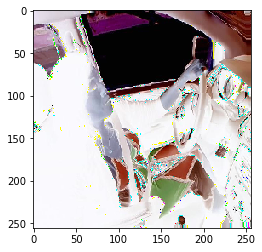

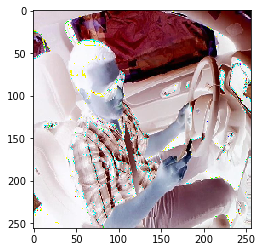

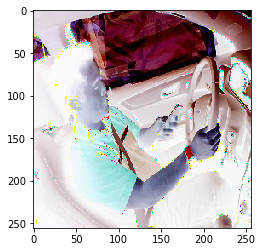

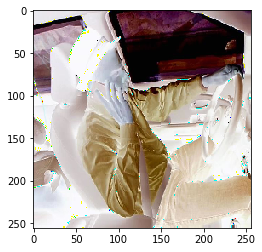

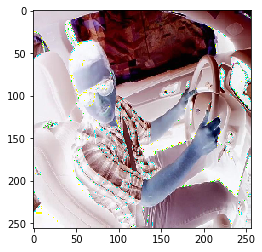

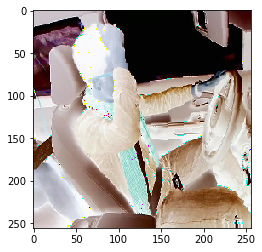

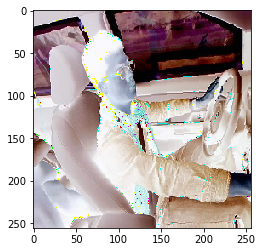

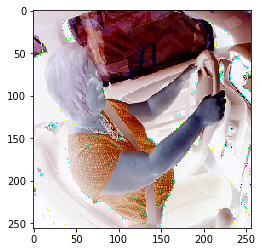

In [109]:
for pic in rota_aug.next()[0]:
    plt.imshow(pic.transpose(1,2,0),cmap='gray')
    plt.figure()

---
Train model on different data_aug to see which work well

In [11]:
def train_model(batches):
    # create model from above
    model = Sequential()
    model.add(BatchNormalization(axis=1,input_shape=(3,224,224)))
    model.add(Conv2D(32,3,3,init=he_normal,activation='relu',border_mode='same'))
    model.add(Conv2D(32,3,3,init=he_normal,activation='relu',border_mode='same'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(64,3,3,init=he_normal,activation='relu',border_mode='same'))
    model.add(Conv2D(64,3,3,init=he_normal,activation='relu',border_mode='same'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu',init=he_normal))
    model.add(Dropout(.5))
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))
    
    model.compile(optimizer=Adam(lr=.001),loss='categorical_crossentropy',metrics=['accuracy'])    
    model.fit_generator(batches,
                    samples_per_epoch=batches.N,
                    nb_epoch=5,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.N)
    return model

In [12]:
width_aug = ImageDataGenerator(width_shift_range=0.1)
batches = get_batches(path+'train',width_aug,batch_size=16)

Found 1500 images belonging to 10 classes.


In [14]:
train_model(batches)

Epoch 1/5
1500/1500 [==============================] - 59s - loss: 2.5238 - acc: 0.2527 - val_loss: 6.6222 - val_acc: 0.1860
Epoch 2/5
1500/1500 [==============================] - 51s - loss: 1.7510 - acc: 0.4113 - val_loss: 1.4349 - val_acc: 0.5120
Epoch 3/5
1500/1500 [==============================] - 51s - loss: 1.3513 - acc: 0.5540 - val_loss: 1.3489 - val_acc: 0.4900
Epoch 4/5
1500/1500 [==============================] - 51s - loss: 1.0952 - acc: 0.6393 - val_loss: 1.2707 - val_acc: 0.5530
Epoch 5/5
1500/1500 [==============================] - 51s - loss: 0.9172 - acc: 0.6973 - val_loss: 1.3286 - val_acc: 0.6070


In [9]:
width_aug = ImageDataGenerator(height_shift_range=0.1)
batches = get_batches(path+'train',width_aug,batch_size=16)

Found 1500 images belonging to 10 classes.


In [8]:
train_model(batches)

Epoch 1/5
1500/1500 [==============================] - 57s - loss: 2.1673 - acc: 0.3607 - val_loss: 4.4977 - val_acc: 0.3140
Epoch 2/5
1500/1500 [==============================] - 53s - loss: 0.8695 - acc: 0.7227 - val_loss: 2.1891 - val_acc: 0.3820
Epoch 3/5
1500/1500 [==============================] - 51s - loss: 0.4785 - acc: 0.8473 - val_loss: 2.1926 - val_acc: 0.3560
Epoch 4/5
1500/1500 [==============================] - 52s - loss: 0.2916 - acc: 0.9200 - val_loss: 1.4576 - val_acc: 0.4800
Epoch 5/5
1500/1500 [==============================] - 52s - loss: 0.1692 - acc: 0.9547 - val_loss: 1.6074 - val_acc: 0.4760


In [13]:
data_aug = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', data_aug, batch_size=16)

Found 1500 images belonging to 10 classes.


In [15]:
model = train_model(batches)

Epoch 1/5
1500/1500 [==============================] - 56s - loss: 2.8027 - acc: 0.1807 - val_loss: 8.7173 - val_acc: 0.1270
Epoch 2/5
1500/1500 [==============================] - 52s - loss: 2.2626 - acc: 0.2800 - val_loss: 1.9502 - val_acc: 0.4280
Epoch 3/5
1500/1500 [==============================] - 52s - loss: 1.9509 - acc: 0.3567 - val_loss: 2.3543 - val_acc: 0.3100
Epoch 4/5
1500/1500 [==============================] - 52s - loss: 1.7673 - acc: 0.4060 - val_loss: 12.5005 - val_acc: 0.0970
Epoch 5/5
1500/1500 [==============================] - 53s - loss: 1.8000 - acc: 0.3960 - val_loss: 4.5966 - val_acc: 0.2620


In [16]:
model = train_model(batches)

GpuArrayException: b'cuMemAlloc: CUDA_ERROR_OUT_OF_MEMORY: out of memory'

In [14]:
model.fit_generator(batches,samples_per_epoch=batches.N,nb_epoch=15,validation_data=val_batches,nb_val_samples=val_batches.N)

NameError: name 'model' is not defined